### **Importación de librerías**

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
import cv2
import os
import numpy as np
from keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from google.colab import drive

### **Montar acceso a Google Drive**

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### **Descomprimir dataset**

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/Datasets/DEF.zip' -d '/content/drive/MyDrive/Colab Notebooks/Datasets/'

### **Ruta del dataset**

In [ ]:
ruta_dataset = '/content/drive/MyDrive/Colab Notebooks/Datasets/DEF'

In [3]:
ruta_prueba = '/content/drive/MyDrive/Colab Notebooks/Datasets/prueba'

### **Visualización del dataset**

In [ ]:
def mostrar_dataset(carpeta, titulo):
    plt.figure(figsize=(10, 10))

    imagenes = os.listdir(carpeta)
    num_imagenes_a_mostrar = min(len(imagenes), 5)

    filas = 5
    columnas = 5

    for i, nombreimg in enumerate(imagenes[:num_imagenes_a_mostrar]):
        plt.subplot(filas, columnas, i + 1)
        imagen = mpimg.imread(os.path.join(carpeta, nombreimg))

        # Verificar si la imagen ya está en escala de grises
        if len(imagen.shape) == 2 or imagen.shape[-1] == 1:
            plt.imshow(imagen, cmap='gray')
        else:
            plt.imshow(imagen)

        plt.title(titulo)
        plt.axis('off')

    plt.show()

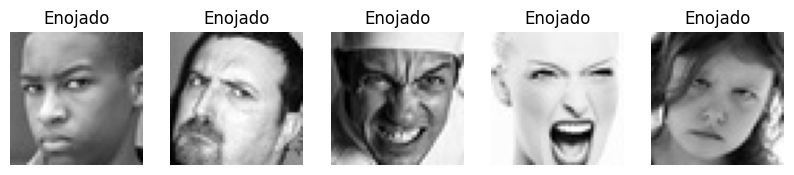

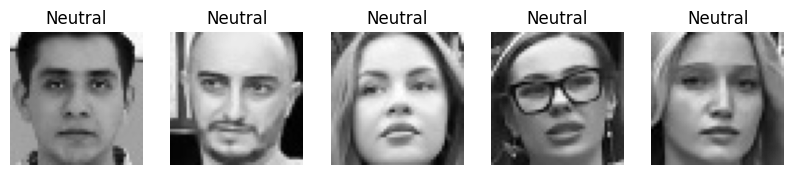

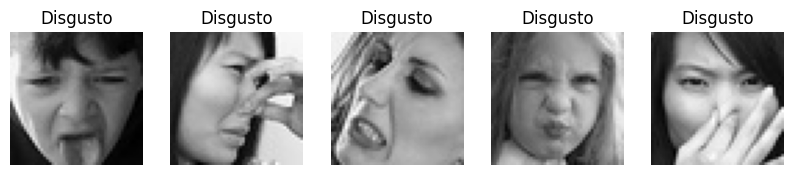

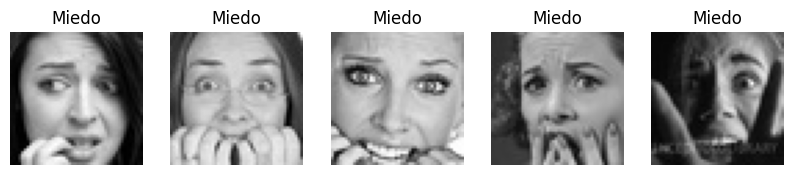

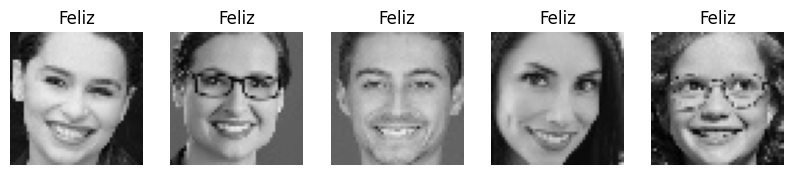

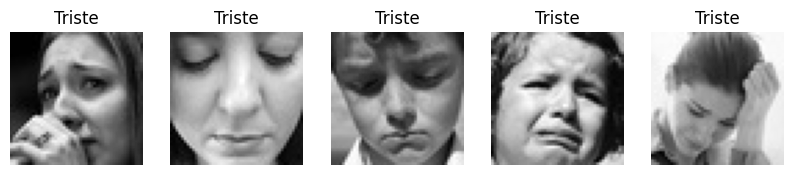

In [ ]:
# Visualización del dataset
emociones = ['Enojado', 'Neutral', 'Disgusto', 'Miedo', 'Feliz', 'Triste']

for i, emocion in enumerate(emociones):
    mostrar_dataset(f"{ruta_dataset}/{i}", emocion)

### **Carga de Imágenes y Etiquetas para Procesamiento**

In [4]:
def cargar_imagenes_y_etiquetas(ruta):
    X = []
    y = []

    for categoria in os.listdir(ruta):
        ruta_categoria = os.path.join(ruta, categoria)
        numero_clase = int(categoria)

        for archivo_img in os.listdir(ruta_categoria):
            ruta_img = os.path.join(ruta_categoria, archivo_img)

            img = cv2.imread(ruta_img, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            img = img / 255.0

            X.append(img)
            y.append(numero_clase)

    return np.array(X), np.array(y)

In [ ]:
# Carga del dataset
X, y = cargar_imagenes_y_etiquetas(ruta_dataset)

In [5]:
# Carga del conjunto para prueba
X_prueba, y_prueba = cargar_imagenes_y_etiquetas(ruta_prueba)

In [ ]:
# Mostrar número de imágenes por clase
for clase in range(6):
    num_imagenes_clase = np.sum(y == clase)
    print(f'Clase {clase}: {num_imagenes_clase}')

Clase 0: 1000
Clase 1: 1000
Clase 2: 1000
Clase 3: 1000
Clase 4: 1000
Clase 5: 1000


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_entrenamiento.shape

(4800, 48, 48)

In [ ]:
X_entrenamiento = X_entrenamiento.reshape(-1, 48, 48, 1)
X_validacion = X_validacion.reshape(-1, 48, 48, 1)
X_prueba = X_prueba.reshape(-1, 48, 48, 1)

In [6]:
X_prueba = X_prueba.reshape(-1, 48, 48, 1)

In [ ]:
print(f'Entrenamiento: {len(X_entrenamiento)} \nValidación: {len(X_validacion)} \nPrueba: {len(X_prueba)}')

Entrenamiento: 4800 
Validación: 1200 
Prueba: 300


### **Aumento de Datos**

In [ ]:
# Configuración del aumento de datos
entrenamiento_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.01,
    height_shift_range=0.01,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
entrenamiento_datagen.fit(X_entrenamiento)

### **Arquitectura del modelo CNN**

In [ ]:
modelo = models.Sequential([

    layers.BatchNormalization(input_shape=(48, 48, 1)),

    layers.Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(6, activation="softmax")
])

In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 48, 48, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:
# Definir EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

### **Configuración del Optimizador y Compilación del Modelo**

In [ ]:
opt = Adam(learning_rate=0.0001)

modelo.compile(optimizer=opt,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

### **Entrenamiento del Modelo**

In [ ]:
historial = modelo.fit(
    entrenamiento_datagen.flow(X_entrenamiento, y_entrenamiento, batch_size=64),
    epochs=100,
    validation_data=(X_validacion, y_validacion),
    callbacks=[early_stopping]
)

Epoch 1/100
75/75 [==============================] - 15s 68ms/step - loss: 1.7833 - accuracy: 0.2281 - val_loss: 1.7715 - val_accuracy: 0.1933
Epoch 2/100
75/75 [==============================] - 6s 74ms/step - loss: 1.7021 - accuracy: 0.2800 - val_loss: 1.6780 - val_accuracy: 0.3575
Epoch 3/100
75/75 [==============================] - 4s 51ms/step - loss: 1.6248 - accuracy: 0.3350 - val_loss: 1.5649 - val_accuracy: 0.4267
Epoch 4/100
75/75 [==============================] - 5s 63ms/step - loss: 1.5567 - accuracy: 0.3798 - val_loss: 1.4008 - val_accuracy: 0.4925
Epoch 5/100
75/75 [==============================] - 5s 62ms/step - loss: 1.4724 - accuracy: 0.4238 - val_loss: 1.2434 - val_accuracy: 0.5242
Epoch 6/100
75/75 [==============================] - 4s 55ms/step - loss: 1.3855 - accuracy: 0.4554 - val_loss: 1.1170 - val_accuracy: 0.6033
Epoch 7/100
75/75 [==============================] - 4s 58ms/step - loss: 1.2779 - accuracy: 0.5169 - val_loss: 1.1201 - val_accuracy: 0.5650
Epoch

In [ ]:
nombre_modelo = "DEF.h5"
modelo.save(nombre_modelo)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Evaluación del Modelo**


In [7]:
from keras.models import load_model

In [8]:
modelo = load_model('/content/drive/MyDrive/Colab Notebooks/Modelos entrenados/DEF.h5')  # Reemplaza con la ruta de tu modelo

In [9]:
modelo.evaluate(X_prueba, y_prueba)

10/10 [==============================] - 3s 43ms/step - loss: 0.0630 - accuracy: 1.0000


[0.06300091743469238, 1.0]

**Matriz de Confusión**

10/10 [==============================] - 0s 11ms/step


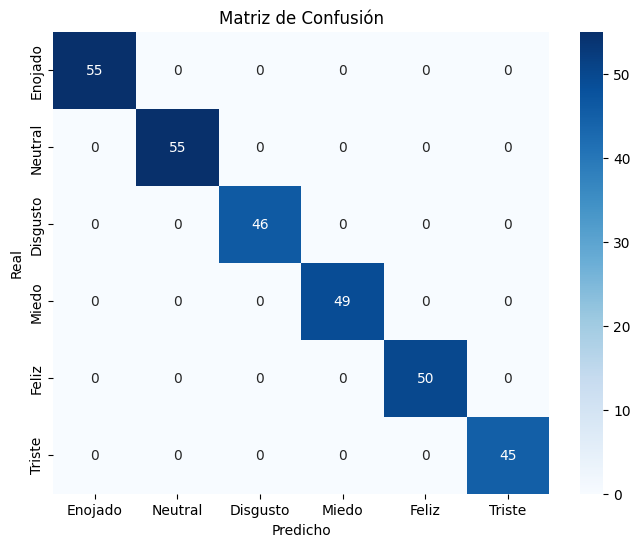

In [10]:
# Obtener las predicciones del modelo en el conjunto de prueba
predicciones_y = modelo.predict(X_prueba)

# Convertir las predicciones a etiquetas numéricas
etiquetas_predichas_y = np.argmax(predicciones_y, axis=1)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_prueba, etiquetas_predichas_y)

# Definir las etiquetas de clase
etiquetas_clase = ['Enojado', 'Neutral', 'Disgusto', 'Miedo', 'Feliz', 'Triste']

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_clase, yticklabels=etiquetas_clase)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

**Visualización de imágenes mal calificadas**

2/2 [==============================] - 0s 464ms/step


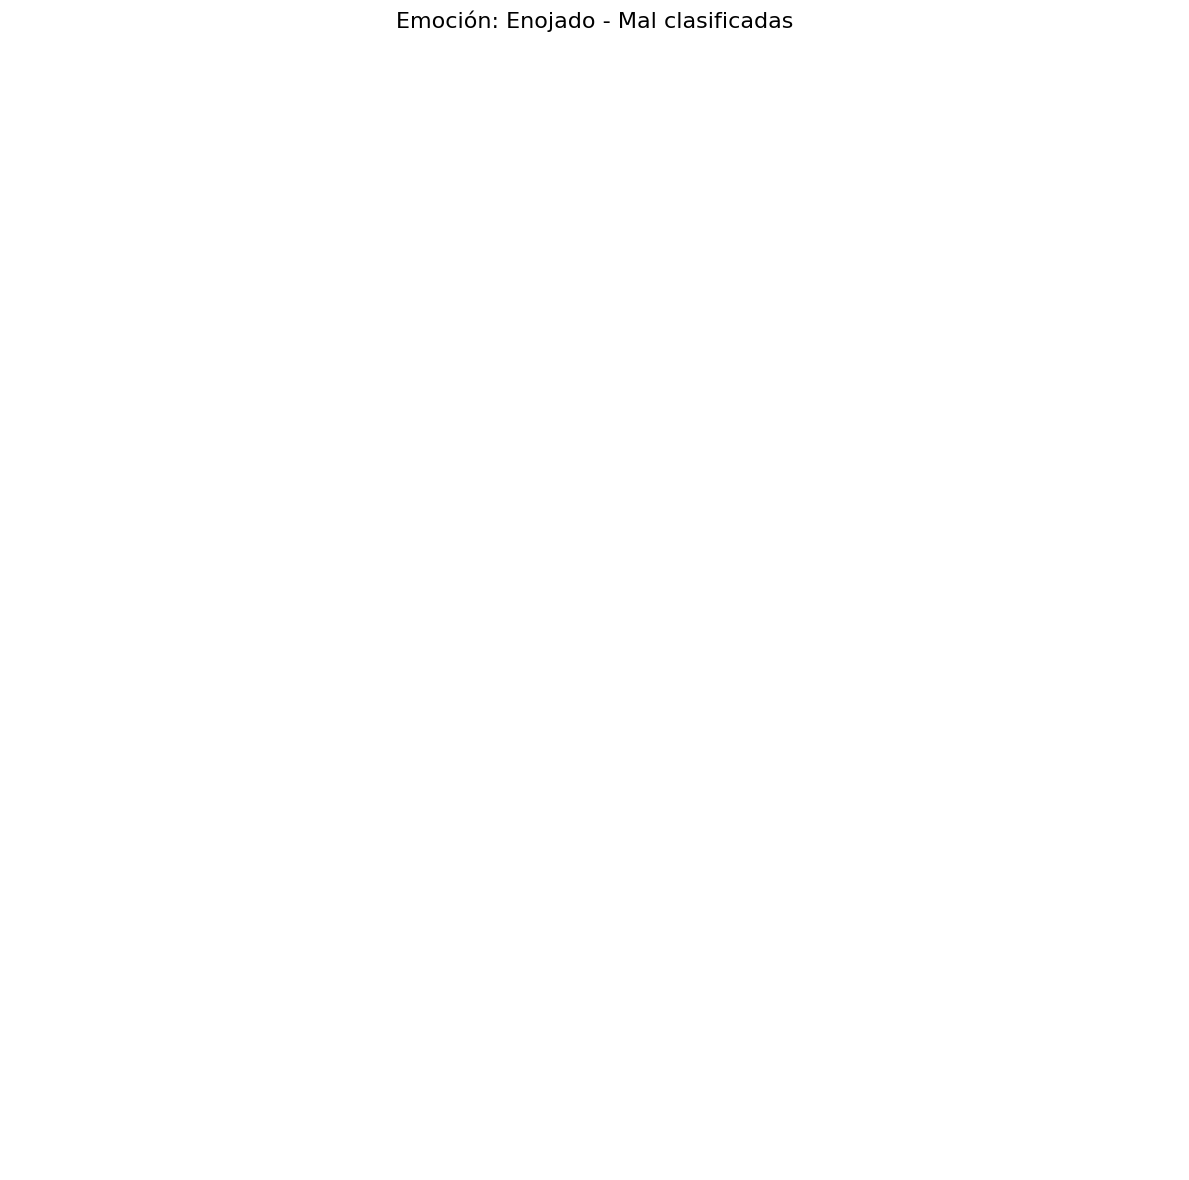

2/2 [==============================] - 0s 9ms/step


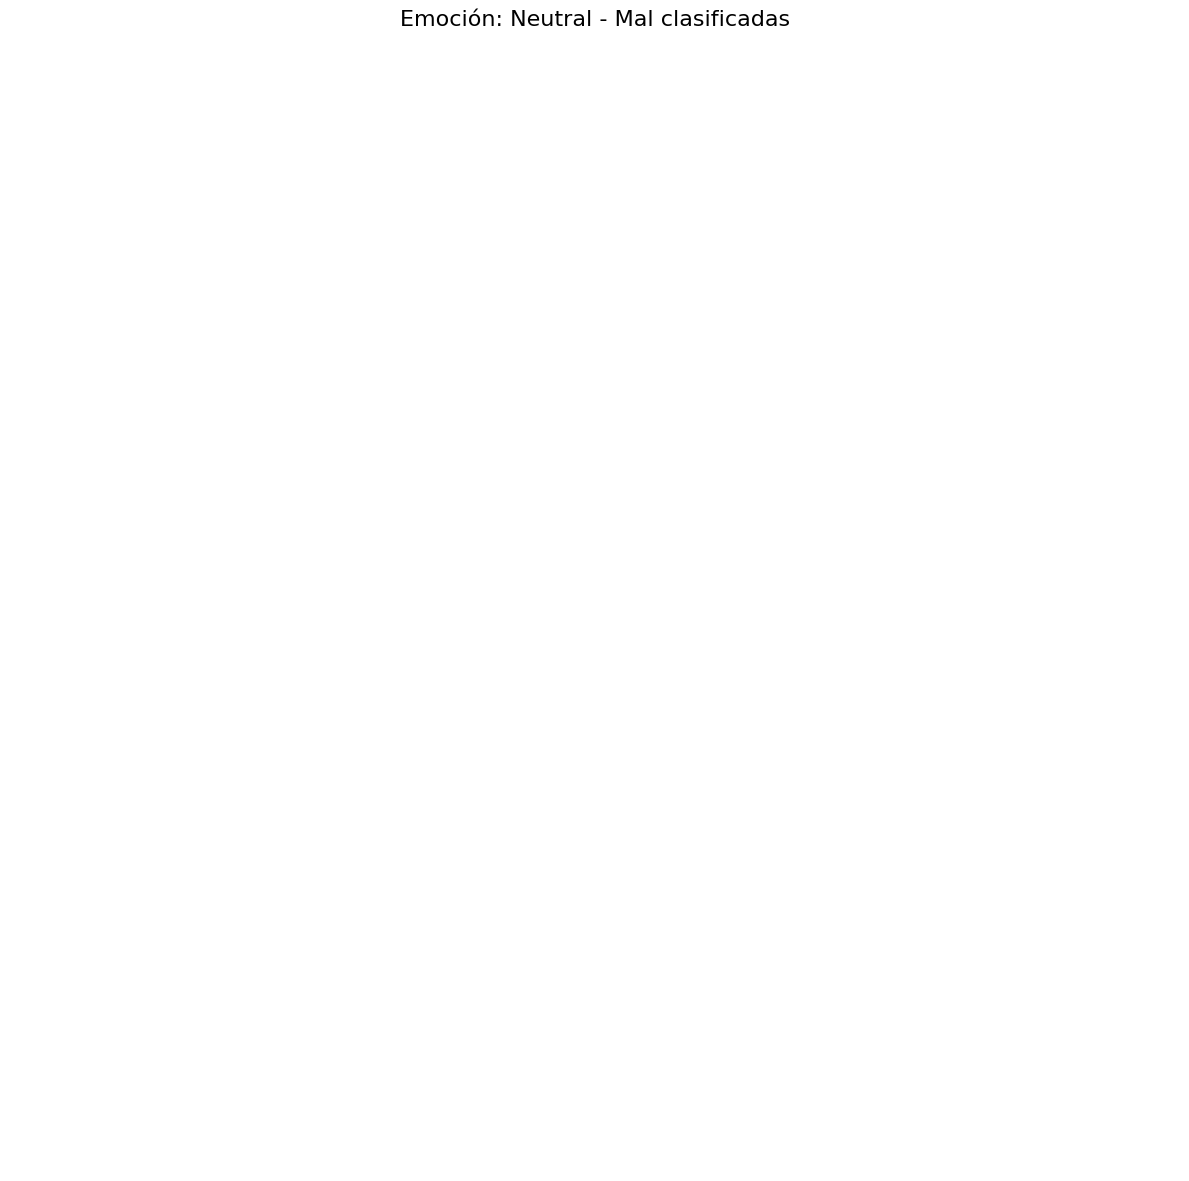

2/2 [==============================] - 0s 277ms/step


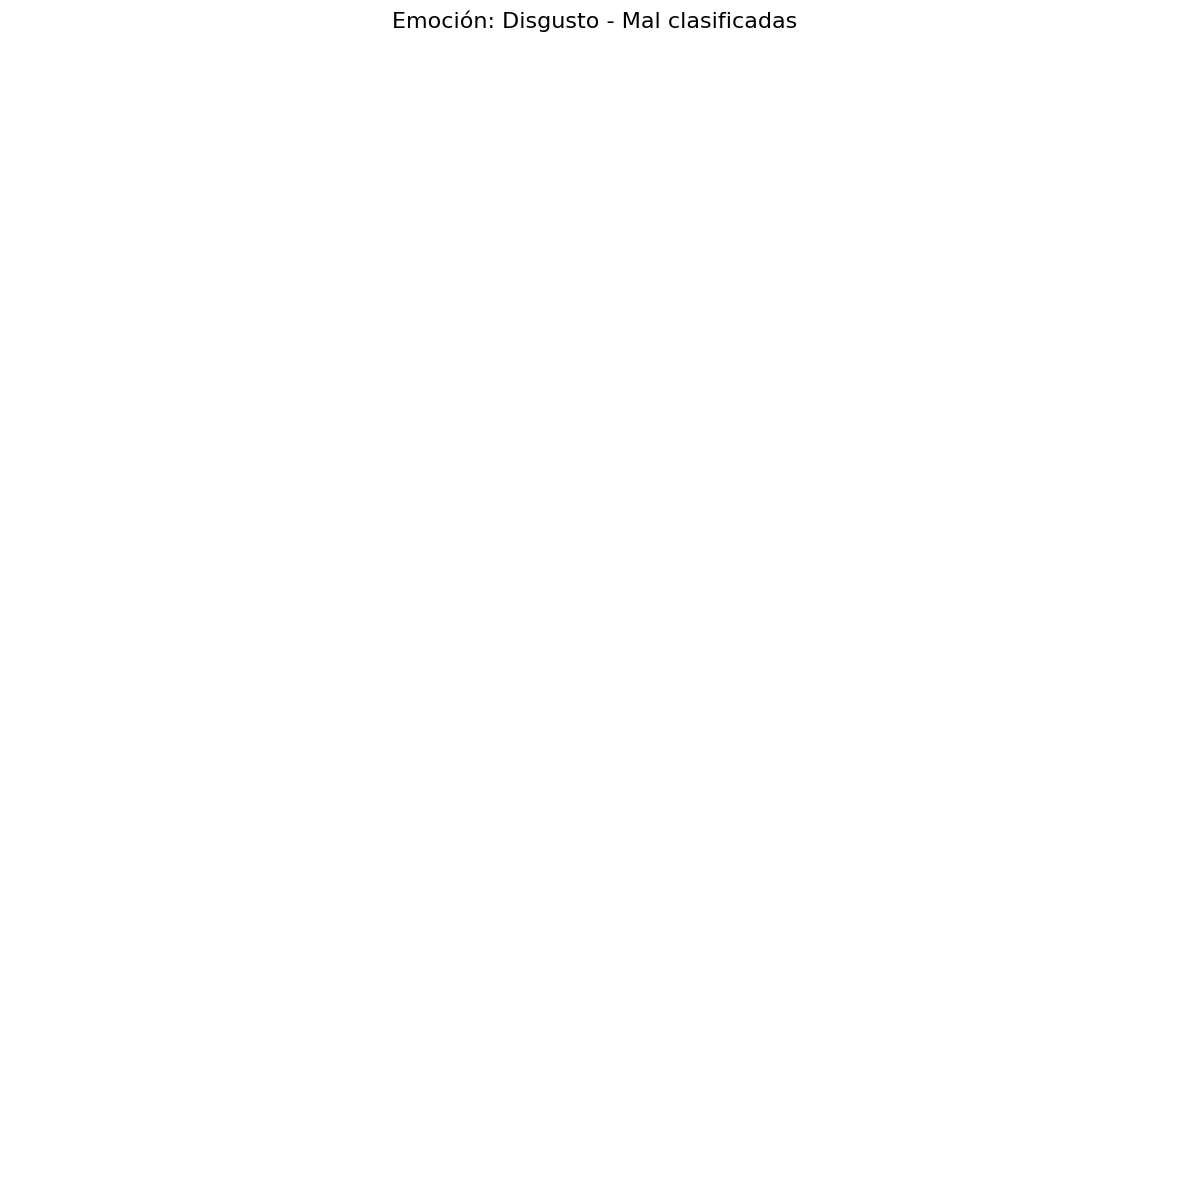

2/2 [==============================] - 0s 297ms/step


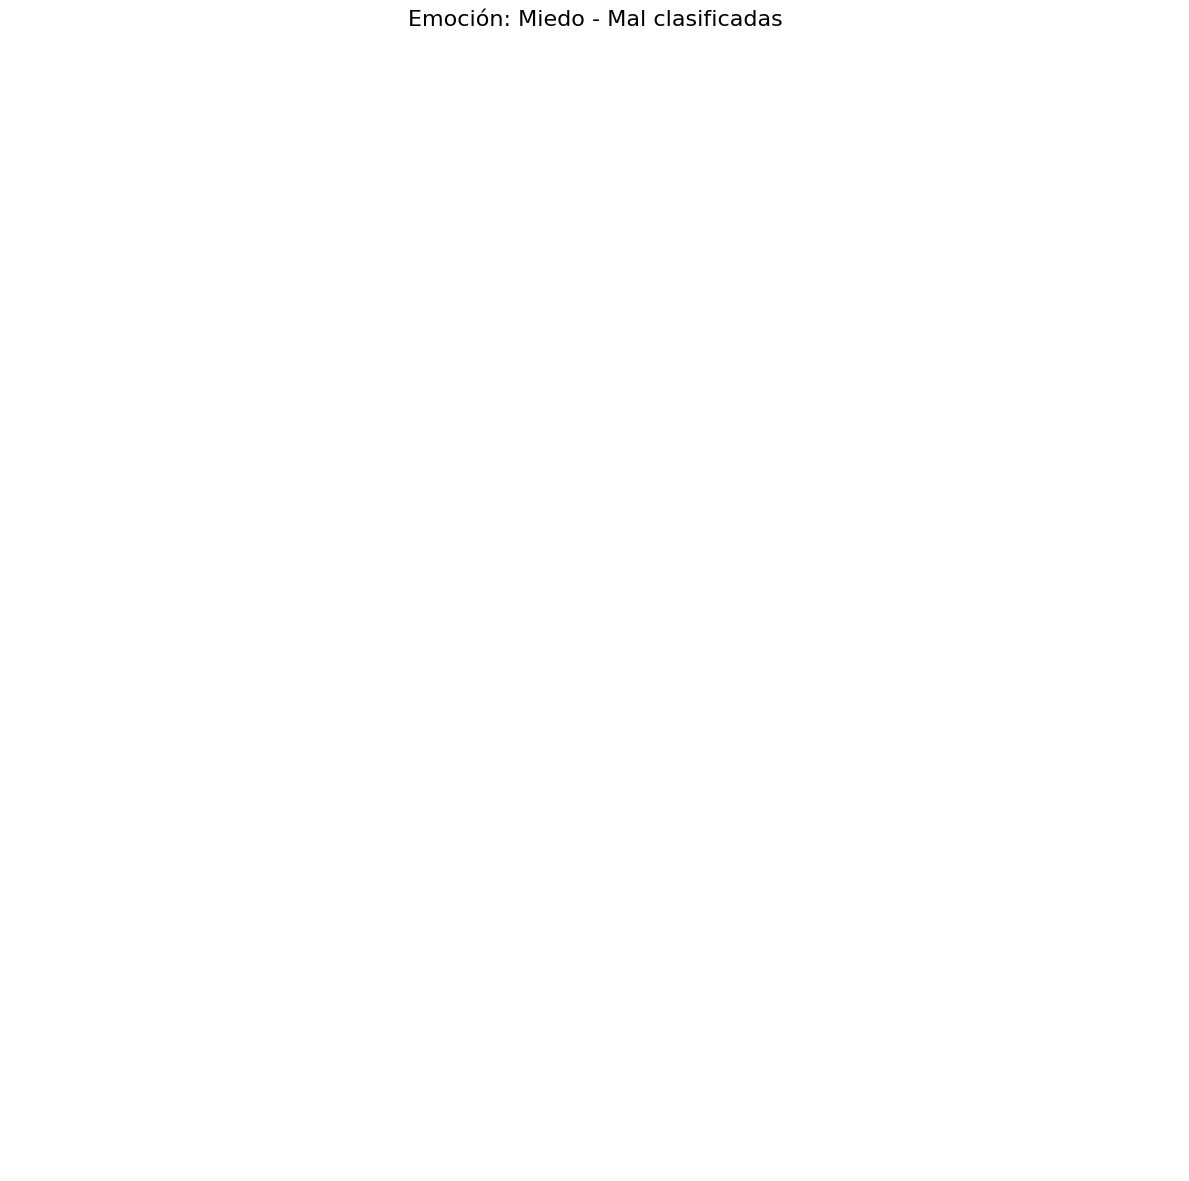

2/2 [==============================] - 0s 316ms/step


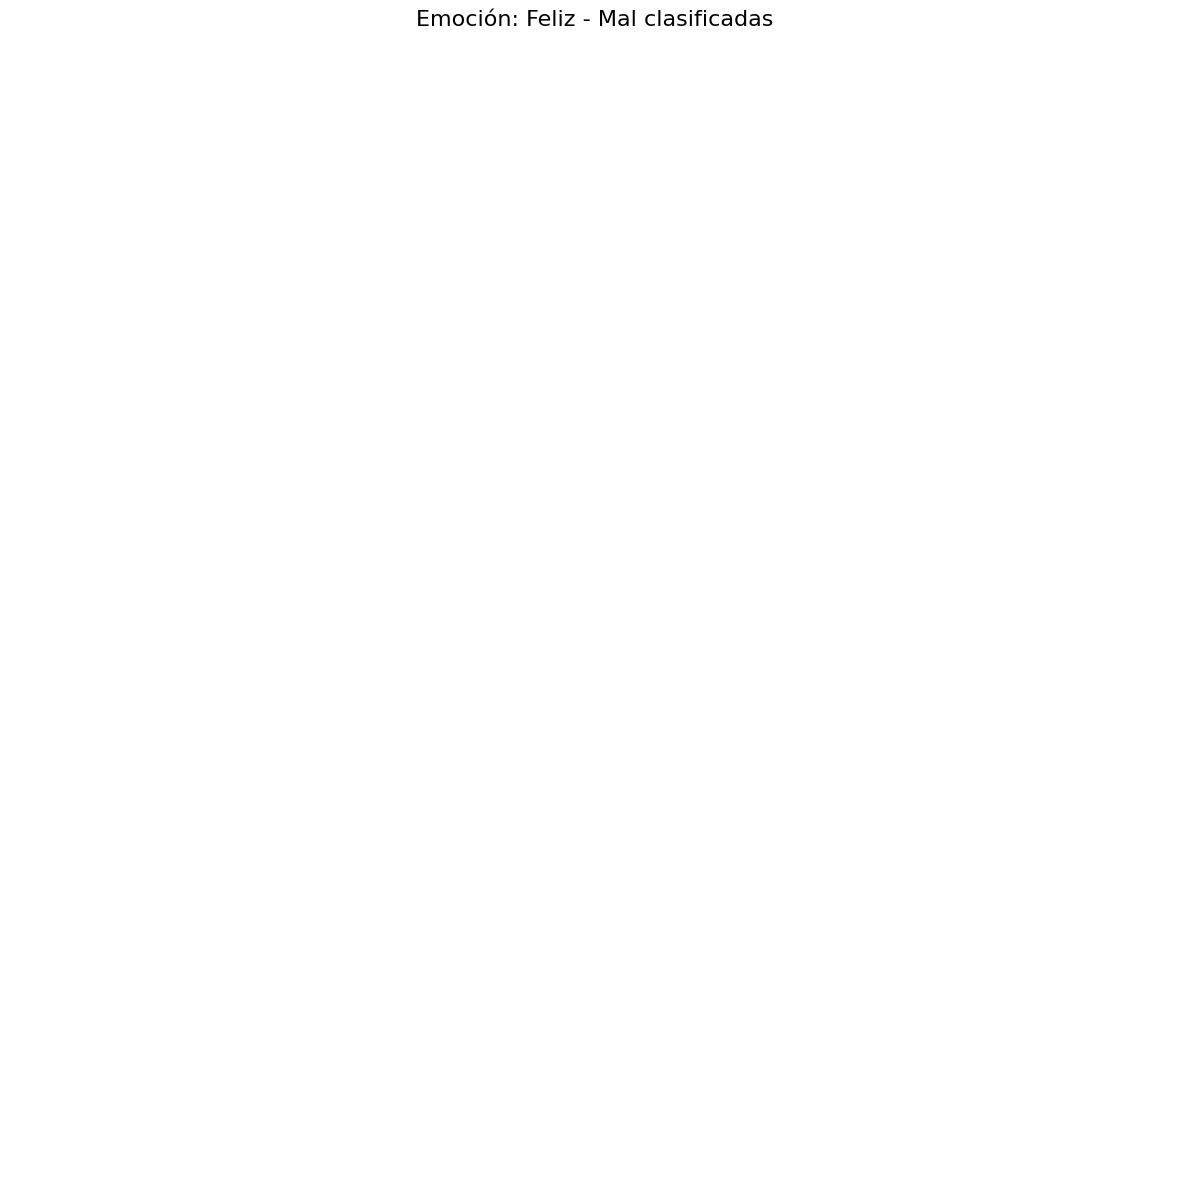

2/2 [==============================] - 0s 269ms/step


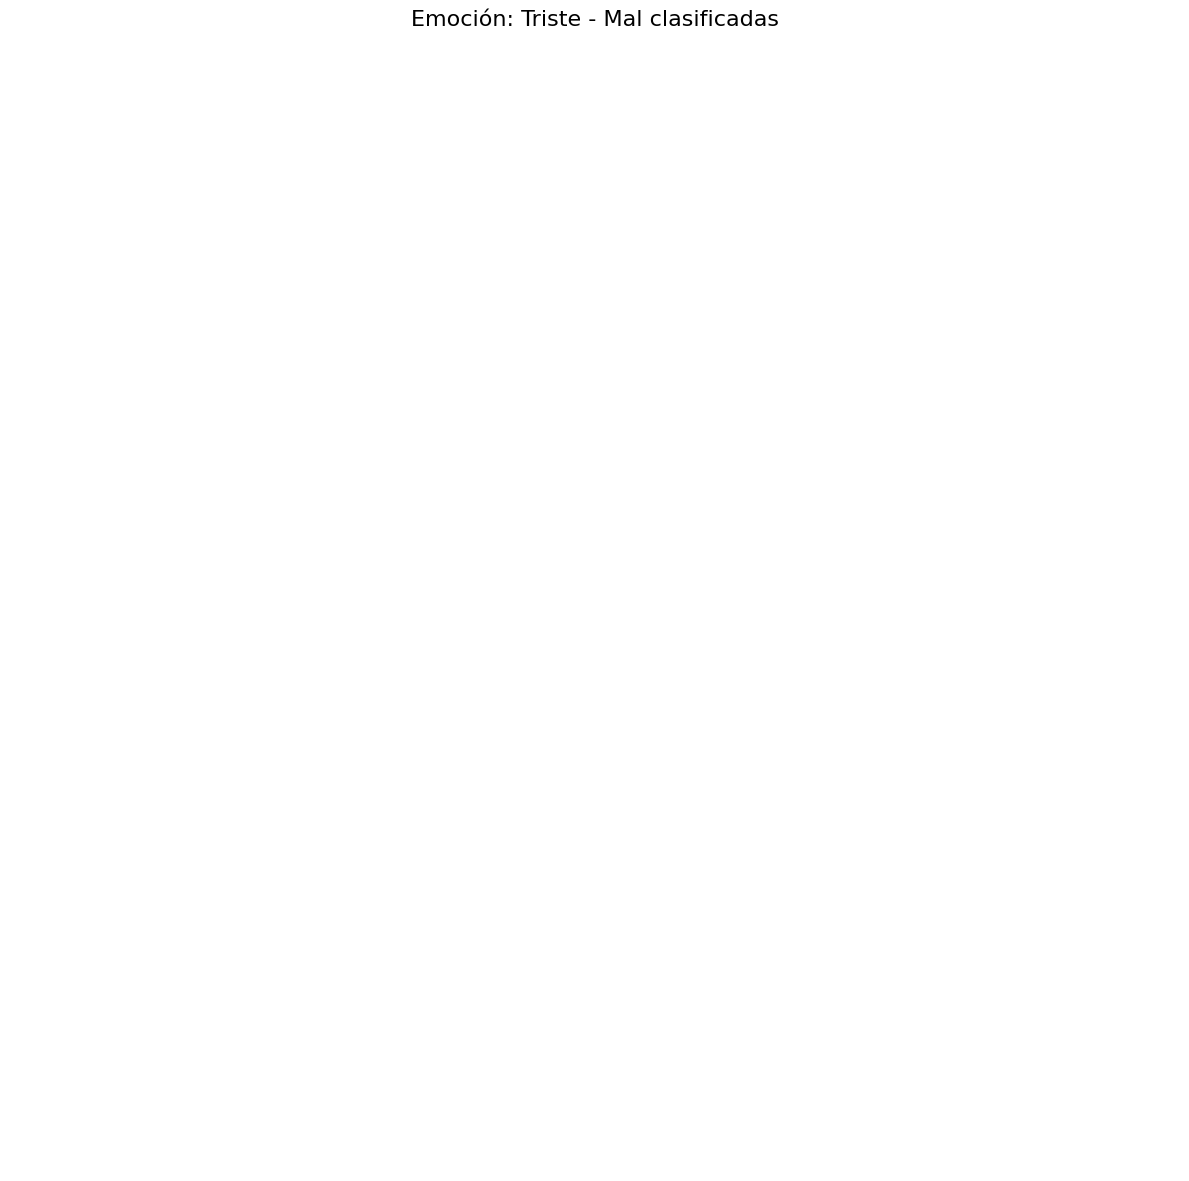

In [11]:
def mostrar_imagenes_incorrectas_por_emocion(emocion, imagenes_emocion, etiquetas_emocion, etiquetas_predichas_emocion, num_filas=5, num_columnas=5):
    fig, axs = plt.subplots(num_filas, num_columnas, figsize=(12, 12))
    fig.suptitle(f'Emoción: {etiquetas_clase[emocion]} - Mal clasificadas', fontsize=16)

    mal_clasificadas = np.where(etiquetas_emocion != etiquetas_predichas_emocion)[0]
    contador_imagenes = 0

    for i in range(num_filas):
        for j in range(num_columnas):
            if contador_imagenes < len(mal_clasificadas):
                index = mal_clasificadas[contador_imagenes]
                axs[i, j].imshow(imagenes_emocion[index].squeeze(), cmap='gray')
                axs[i, j].set_title(f'Real: {etiquetas_clase[etiquetas_emocion[index]]}\n'
                                    f'Predicho: {etiquetas_clase[etiquetas_predichas_emocion[index]]}')
                axs[i, j].axis('off')
                contador_imagenes += 1
            else:
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar solo las imágenes mal clasificadas
for emocion in range(6):
    # Filtrar las imágenes por cada emoción en el conjunto de prueba
    indices_emocion = np.where(y_prueba == emocion)[0]
    imagenes_emocion = X_prueba[indices_emocion]
    etiquetas_emocion = y_prueba[indices_emocion]

    # Obtener las predicciones para las imágenes de esta emoción
    predicciones_emocion = modelo.predict(imagenes_emocion)
    etiquetas_predichas_emocion = np.argmax(predicciones_emocion, axis=1)

    mostrar_imagenes_incorrectas_por_emocion(emocion, imagenes_emocion, etiquetas_emocion, etiquetas_predichas_emocion)

**Métricas de Rendimiento**

In [12]:
accuracy = accuracy_score(y_prueba, etiquetas_predichas_y)
precision = precision_score(y_prueba, etiquetas_predichas_y, average='weighted')
recall = recall_score(y_prueba, etiquetas_predichas_y, average='weighted')
f1 = f1_score(y_prueba, etiquetas_predichas_y, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nReporte de clasificación:")
print(classification_report(y_prueba, etiquetas_predichas_y))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        46
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        45

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



**Visualización de la Pérdida en Entrenamiento y Validación a lo largo de las Épocas**

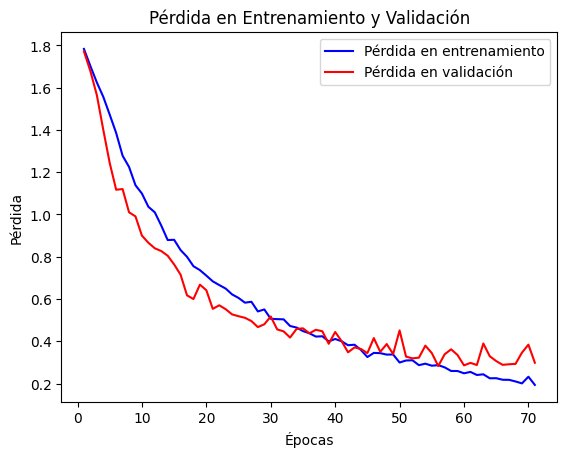

In [ ]:
# Obtener datos de pérdida del historial
pérdida_entrenamiento = historial.history['loss']
pérdida_validación = historial.history['val_loss']

# Crear un rango para el número de épocas
épocas = range(1, len(pérdida_entrenamiento) + 1)

# Graficar la pérdida en el conjunto de entrenamiento y validación
plt.plot(épocas, pérdida_entrenamiento, 'b', label='Pérdida en entrenamiento')
plt.plot(épocas, pérdida_validación, 'r', label='Pérdida en validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

**Visualización de la Precisión en Entrenamiento y Validación a lo largo de las Épocas**

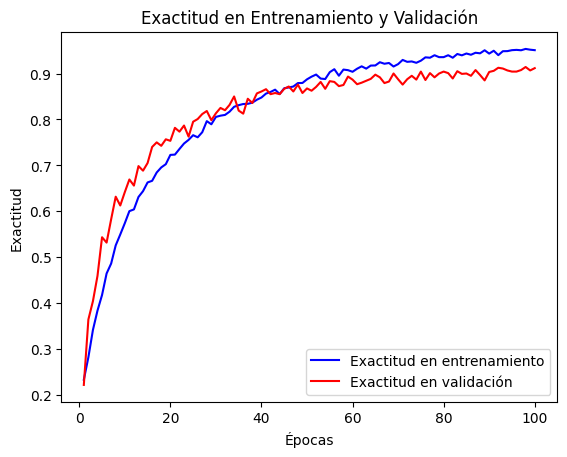

In [ ]:
# Obtener datos de precisión del historial
exactitud_entrenamiento = historial.history['accuracy']
exactitud_validacion = historial.history['val_accuracy']

# Crear un rango para el número de épocas
epocas = range(1, len(exactitud_entrenamiento) + 1)

# Graficar la precisión en el conjunto de entrenamiento y validación
plt.plot(epocas, exactitud_entrenamiento, 'b', label='Exactitud en entrenamiento')
plt.plot(epocas, exactitud_validacion, 'r', label='Exactitud en validación')
plt.title('Exactitud en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

### **Visualización de Activaciones**

1/1 [==============================] - 0s 87ms/step


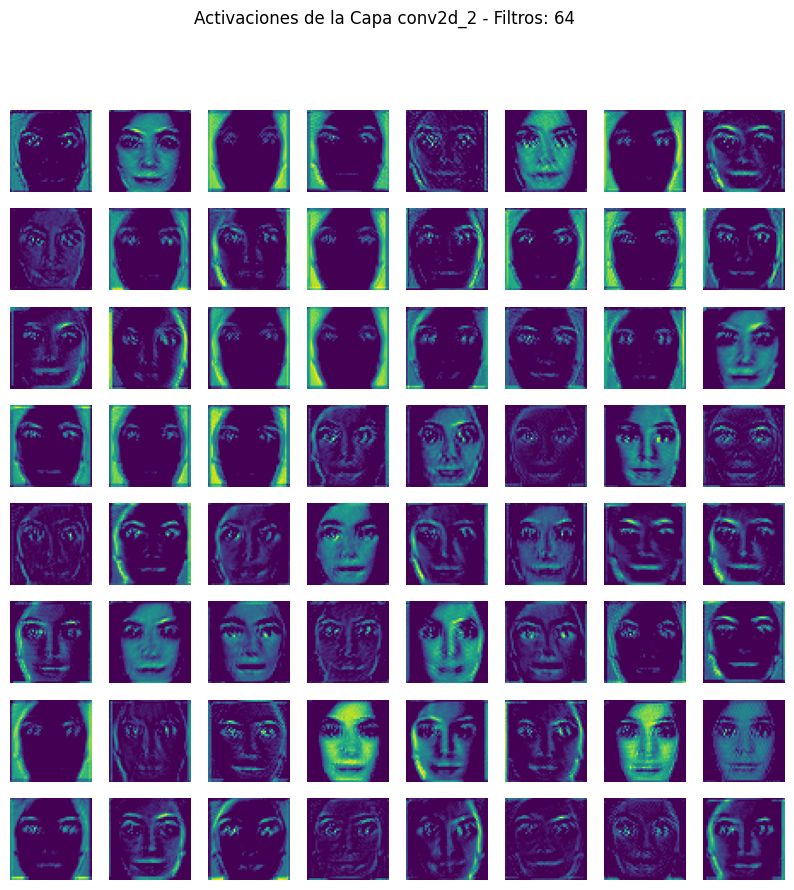

1/1 [==============================] - 0s 252ms/step


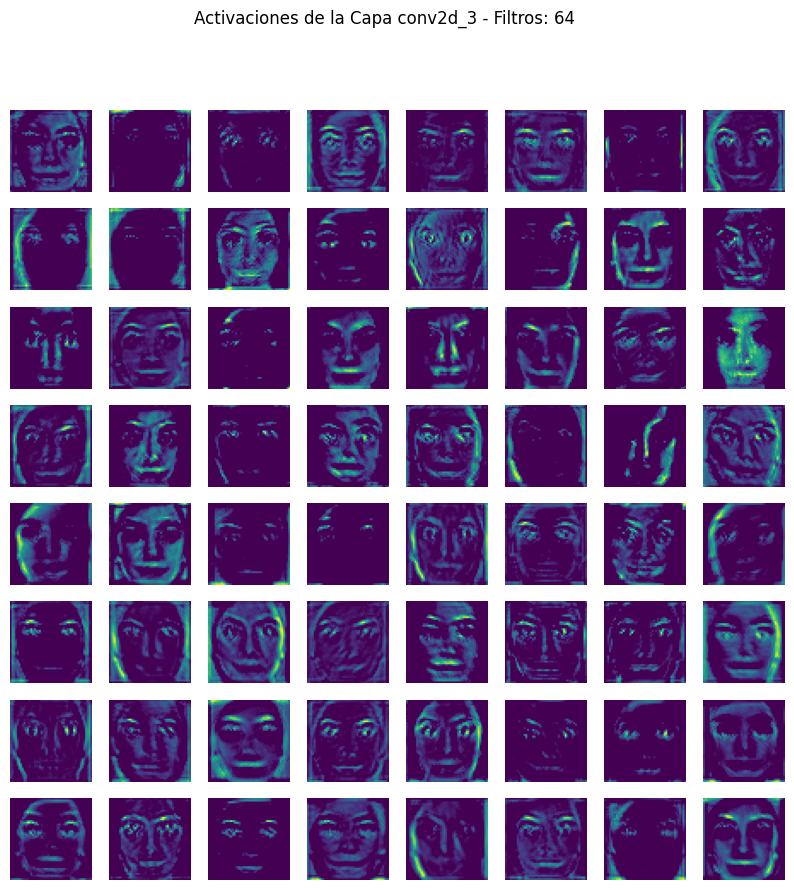

1/1 [==============================] - 0s 159ms/step


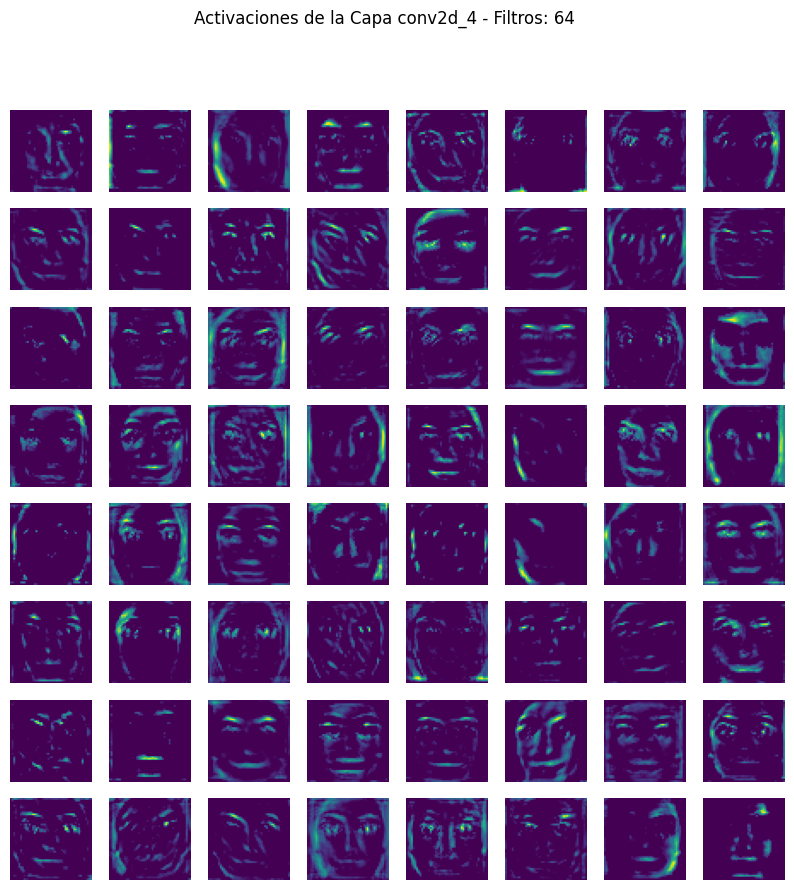

1/1 [==============================] - 0s 161ms/step


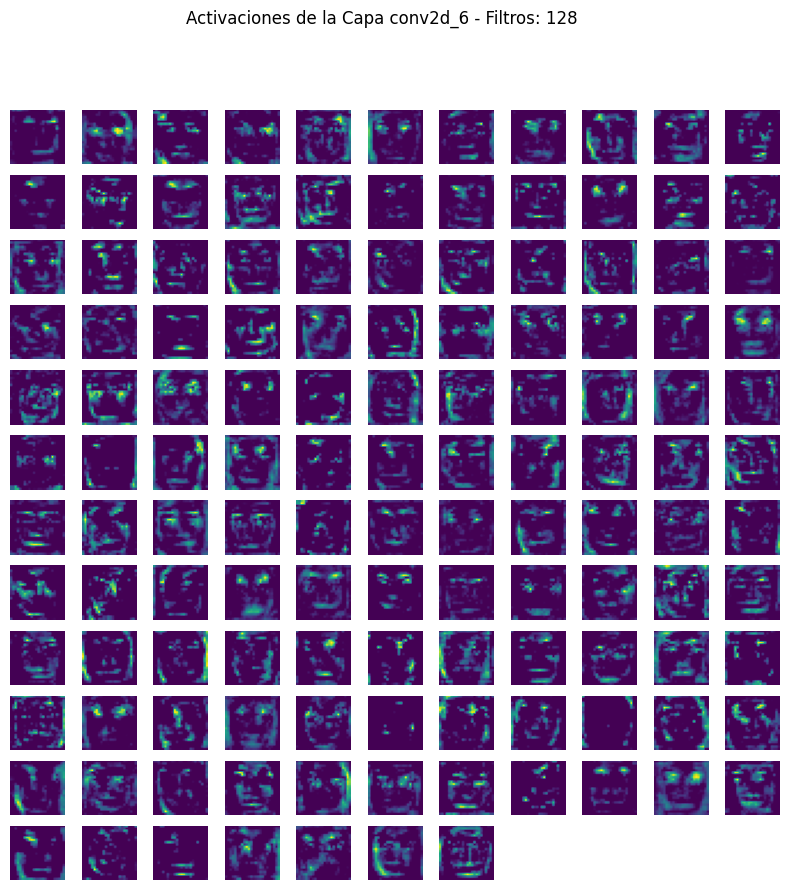

1/1 [==============================] - 0s 321ms/step


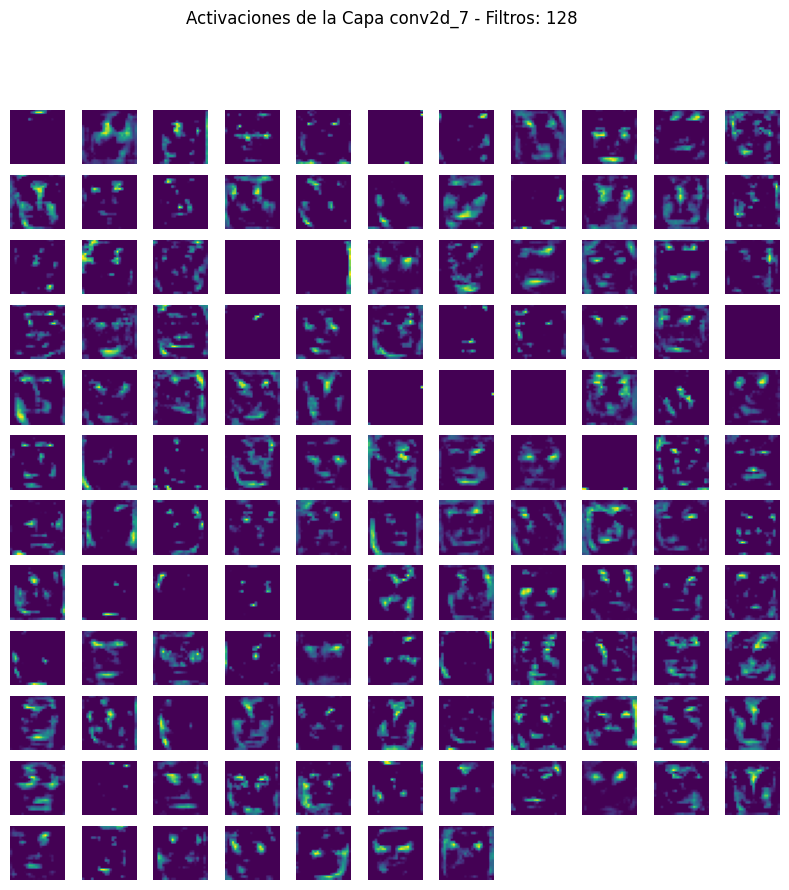

1/1 [==============================] - 0s 196ms/step


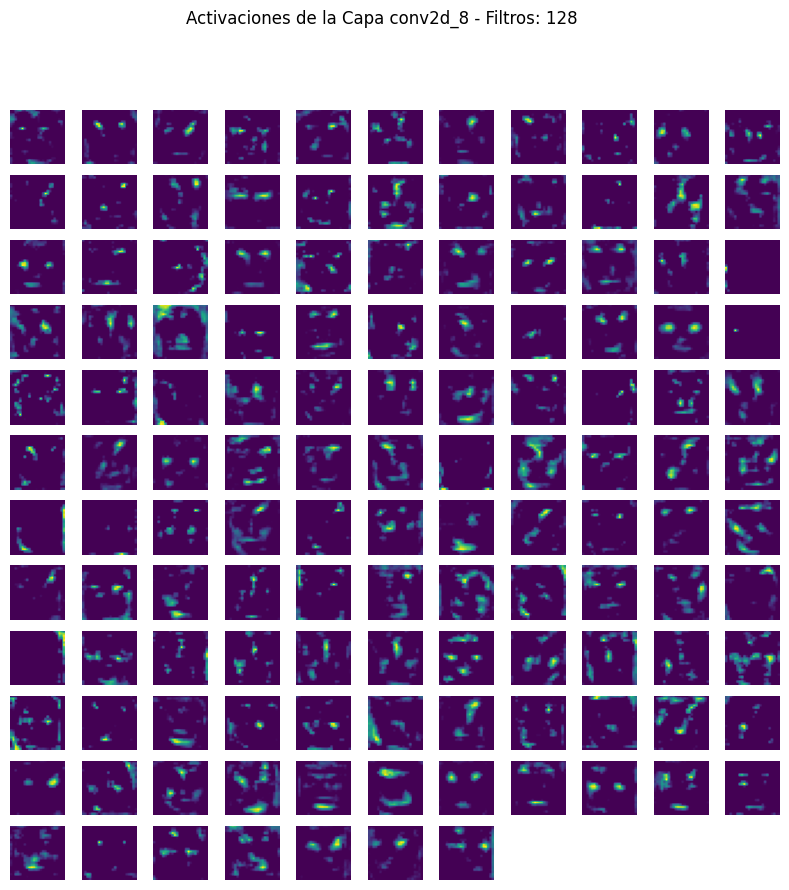

1/1 [==============================] - 0s 171ms/step


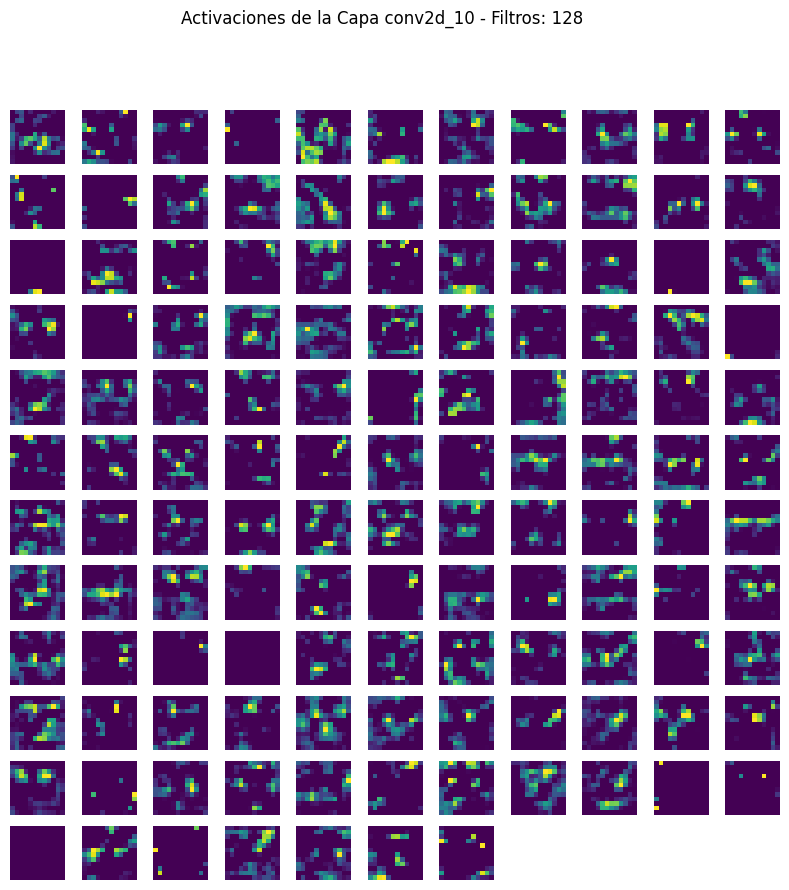

1/1 [==============================] - 0s 142ms/step


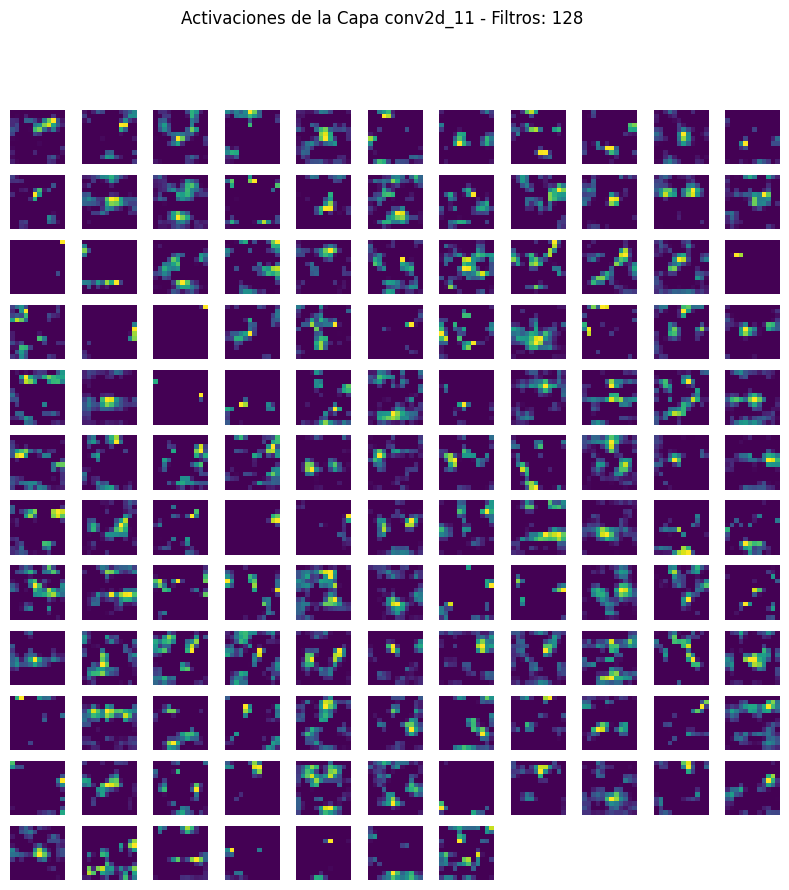

1/1 [==============================] - 0s 160ms/step


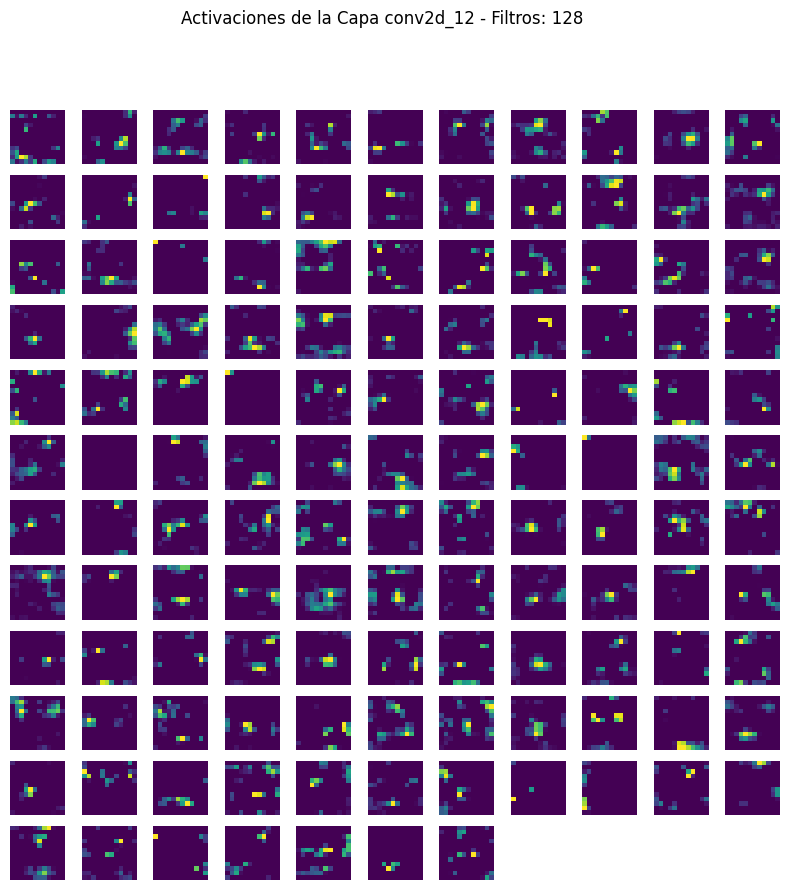

In [13]:
from tensorflow.keras.models import Model

# Visualizar las activaciones de todas las capas convolucionales y mostrarlas
for i, capa in enumerate(modelo.layers):
    if isinstance(capa, tf.keras.layers.Conv2D):  # Verificar si la capa es Conv2D

        nombre_capa = f"conv2d_{i + 1}"
        filtros = capa.output.shape[-1]  # Obtener el número de filtros de la capa

        # Crear un modelo que devuelve las activaciones de esta capa para una entrada dada
        modelo_capa = Model(inputs=modelo.input, outputs=capa.output)

        imagen_muestra = X_prueba[1]
        imagen_muestra = np.expand_dims(imagen_muestra, axis=0)

        # Obtener las activaciones para la imagen seleccionada en esta capa
        activaciones = modelo_capa.predict(imagen_muestra)

        # Calcular el diseño del gráfico basado en el número de filtros
        filas = int(np.ceil(np.sqrt(filtros)))
        columnas = int(np.ceil(filtros / filas))

        # Visualizar las activaciones de esta capa
        plt.figure(figsize=(10, 10))
        for j in range(filtros):
            plt.subplot(filas, columnas, j + 1)  # Ajustar el diseño del gráfico
            plt.imshow(activaciones[0, :, :, j], cmap='viridis')  # Mostrar la activación del filtro 'j'
            plt.axis('off')
        plt.suptitle(f'Activaciones de la Capa {nombre_capa} - Filtros: {filtros}')  # Título general para la visualización
        plt.show()